In [ ]:
%load_ext autoreload
%autoreload 2


In [1]:
# change directory to the root of the project
from os import chdir

chdir("../")


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

from bs4 import BeautifulSoup


In [3]:
def html_table_to_xlsx(
    url: str,
    table_id: str,
    filename: str,
) -> pd.DataFrame:
    """Converts table of given `table_id` from given `url` to an Excel file.

    Parameters
    ----------
    url : str
        URL of the HTML page.
    table_id : str
        ID of the table to be converted.
    filename : str
        Path where to save the generated .xlsx file.
    """
    # send a request to the server to get the HTML
    response = requests.get(url)

    # parse the HTML with BeautifulSoup
    soup = BeautifulSoup(response.text, "html.parser")

    # gGet the table by ID
    table = soup.find(id=table_id)

    # read the table into a pandas DataFrame
    df = pd.read_html(str(table))[0]
    df.drop(columns=["Unnamed: 0"], inplace=True)
    df.rename(
        columns={
            "Código Nacional": "national_code",
            "Código OMM": "WMO_code",
            "Código Organismo": "agency_code",
            "Nombre": "name",
            "Región": "state",
            "Altitud (Mts.)": "altitude",
            "Propietario": "owner",
            "Fono Contacto": "contact_phone",
        },
        inplace=True,
    )
    df.set_index("national_code", inplace=True, drop=True)

    # save the DataFrame to an Excel file
    df.to_excel(filename, index=False)

    return df


url = "https://climatologia.meteochile.gob.cl/application/informacion/estacionesEnGrupo/CalculoOlasCalor"
table_id = "excel"
filename = "hw_stations.xlsx"

avl_stations = html_table_to_xlsx(url, table_id, filename)
print(avl_stations.shape)
avl_stations.head()


(34, 7)


,WMO_code,agency_code,name,state,altitude,owner,contact_phone
national_code,,,,,,,
180005,85406,NaN,"Chacalluta, Arica Ap.",Arica y Parinacota,50,Dirección Meteorológica de Chile,NaN
200006,85418,NaN,Diego Aracena Iquique Ap.,Tarapacá,48,Dirección Meteorológica de Chile,NaN
220002,85432,NaN,"El Loa, Calama Ad.",Antofagasta,2321,Dirección Meteorológica de Chile,NaN
230001,85442,NaN,Cerro Moreno Antofagasta Ap.,Antofagasta,112,Dirección Meteorológica de Chile,NaN
270001,85469,NaN,Mataveri Isla de Pascua Ap.,Valparaíso,44,Dirección Meteorológica de Chile,NaN


In [4]:
stations_ids = avl_stations.index.to_list()

stations_time_range = pd.DataFrame(columns=["station_id", "min_year", "max_year"])
stations_time_range.set_index("station_id", inplace=True)

# stations time range
for station_id in stations_ids:
    data = pd.read_parquet(f"data/input/stations/{station_id}/daily_temp_history")

    try:
        stations_time_range.loc[station_id] = [data.index.year.min(), data.index.year.max()]

    except AttributeError:  # for stations without data / with problems
        stations_time_range.loc[station_id] = [pd.NA] * 2

stations_time_range.head()


,min_year,max_year
station_id,,
180005,1955,2023
200006,1981,2023
220002,1965,2023
230001,1950,2023
270001,1954,2023


In [9]:
stations = avl_stations.join(stations_time_range)

stations.to_parquet("data/input/stations/hw_research_stations.parquet")

stations.sort_values(by="min_year")


,WMO_code,agency_code,name,state,altitude,owner,contact_phone,min_year,max_year
national_code,,,,,,,,,
370033,85703,NaN,"María Dolores, Los Angeles Ad.",Del Biobío,118,Dirección Meteorológica de Chile,NaN,1950,2023
230001,85442,NaN,Cerro Moreno Antofagasta Ap.,Antofagasta,112,Dirección Meteorológica de Chile,NaN,1950,2023
340045,85608,NaN,Rancagua,Del Libertador Gral. Bernardo O'Higgins,482,Dirección Meteorológica de Chile,NaN,1950,2023
340031,85629,NaN,"General Freire, Curicó Ad.",Del Maule,229,Dirección Meteorológica de Chile,NaN,1950,2023
360011,85672,NaN,"General Bernardo O'Higgins, Chillán Ad.",De Ñuble,155,Dirección Meteorológica de Chile,NaN,1950,2023
330020,85577,NaN,"Quinta Normal, Santiago",Metropolitana de Santiago,520,Dirección Meteorológica de Chile,NaN,1950,2023
460001,85886,NaN,Chile Chico Ad.,Aysén del Gral. Carlos Ibáñez del Campo,311,Dirección Meteorológica de Chile,NaN,1952,2023
450005,85874,NaN,Balmaceda Ad.,Aysén del Gral. Carlos Ibáñez del Campo,517,Dirección Meteorológica de Chile,NaN,1952,2023
450004,85864,NaN,"Teniente Vidal, Coyhaique Ad.",Aysén del Gral. Carlos Ibáñez del Campo,299,Dirección Meteorológica de Chile,NaN,1952,2023


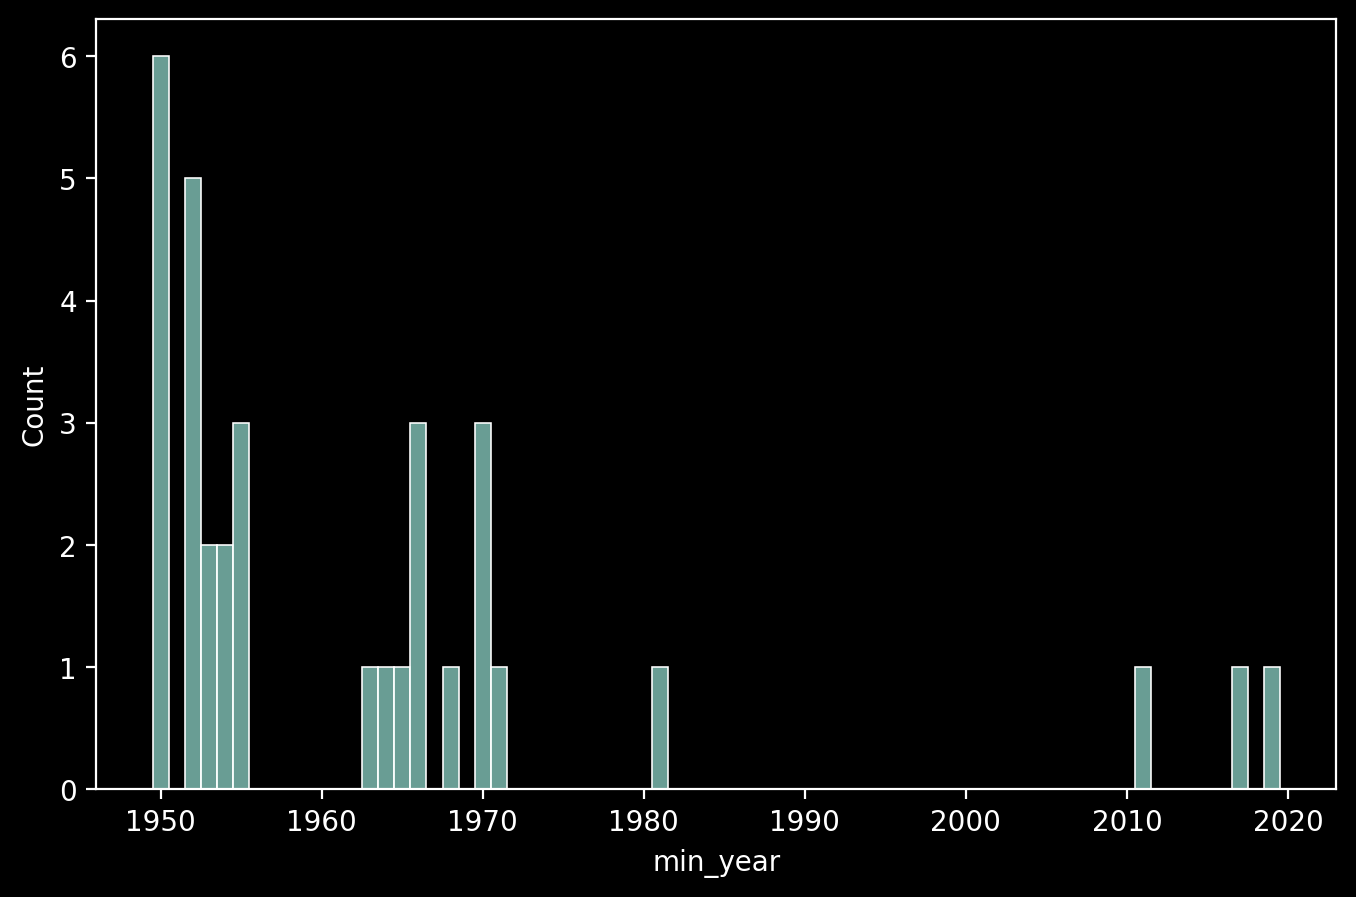

In [6]:
# min_year distribution
sns.histplot(data=stations, x="min_year", bins=50)
plt.show()


In [7]:
pd.read_parquet("data/input/stations/metadata.parquet")


,WMO_code,ICAO_code,name,latitude,longitude,altitude,state_id,geographic_zone_id,data_link
national_code,,,,,,,,,
180005,85406,SCAR,"Chacalluta, Arica Ap.",-18.35555,-70.34028,50,15,1,https://climatologia.meteochile.gob.cl/applica...
180017,85405,,Putre,-18.20000,-69.56250,3532,15,2,https://climatologia.meteochile.gob.cl/applica...
180018,85407,,"Defensa Civil, Arica",-18.49111,-70.30139,71,15,1,https://climatologia.meteochile.gob.cl/applica...
180042,85408,,"Cerro Sombrero, Arica",-18.51250,-70.26556,122,15,1,https://climatologia.meteochile.gob.cl/applica...
200006,85418,SCDA,Diego Aracena Iquique Ap.,-20.54917,-70.18111,48,1,1,https://climatologia.meteochile.gob.cl/applica...
...,...,...,...,...,...,...,...,...,...
950013,0,,"Base O""Higgins - INACH",-63.32167,-57.89778,1,12,1,https://climatologia.meteochile.gob.cl/applica...
950014,0,,Base Prat - INACH,-62.47889,-59.66389,1,12,1,https://climatologia.meteochile.gob.cl/applica...
950015,0,,Punta Armonía,-62.30361,-59.19667,1,12,1,https://climatologia.meteochile.gob.cl/applica...
